In [3]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


In [4]:
#Importing Data
df = pd.read_csv(r"C:\Users\DELL\OneDrive\Documents\Terminus\Portfolio\08. Ticket Forcasting Project\Train.csv")

### EXPLORATORY DATA ANALYSIS

In [5]:
# Generating dataframe shape and size
print(f"DATA EXPLORATION \nDataframe Shape: {df.shape} \nDataframe Size: ({df.size})\n")

# Generating dataframe summary
print(df.info())

# Generating dataframe preview
df.head(3)

DATA EXPLORATION 
Dataframe Shape: (230130, 6) 
Dataframe Size: (1380780)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0


In [6]:
#Checking for nulls
df.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

### FEATURE ENGINEERING

In [7]:
#Converting date column to datatime
df['date'] = pd.to_datetime(df['date'])

# Extract date-related features from 'date' column
df['year'] = pd.to_datetime(df['date']).dt.year
df['quarter'] = pd.to_datetime(df['date']).dt.quarter
df['month'] = pd.to_datetime(df['date']).dt.month
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['day'] = pd.to_datetime(df['date']).dt.day
df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week

# Add sine and cosine transformations for cyclic date features
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df['sin_day'] = np.sin(2 * np.pi * df['day'] / 31)
df['cos_day'] = np.cos(2 * np.pi * df['day'] / 31)
df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['sin_week'] = np.sin(2 * np.pi * df['week'] / 52)
df['cos_week'] = np.cos(2 * np.pi * df['week'] / 52)

In [8]:
#Generating dataframe of only NA values
na_df = df[df['num_sold'].isna()].sort_values(by=['country', 'store', 'product'])

#Grouping na_df by country and store
na_df = na_df.groupby(['country', 'store'])[['product']].value_counts()
print(na_df.head(5))

# Generating dataframe with the median of numbers sold per country, per store, per product
median_per_country_store = df.dropna(subset=['num_sold']).groupby(['country', 'store', 'product'])[['num_sold']].median()
median_per_country_store.head(3)

country  store                 product          
Canada   Discount Stickers     Holographic Goose    2557
                               Kerneler                1
         Premium Sticker Mart  Holographic Goose     380
         Stickers for Less     Holographic Goose    1308
Kenya    Discount Stickers     Holographic Goose    2557
Name: count, dtype: int64


num_sold
country store             product               
Canada  Discount Stickers Kaggle           707.0
                          Kaggle Tiers     584.0
                          Kerneler         319.0

In [9]:
# Fill missing 'num_sold' with median based on country, store, and product
df['num_sold'] = df.apply(
    lambda row: median_per_country_store.loc[(row['country'], row['store'], row['product'])]['num_sold']
    if pd.isna(row['num_sold']) and (row['country'], row['store'], row['product']) in median_per_country_store.index
    else row['num_sold'], axis=1
)

#Checking for NAs
print(df.isna().sum())

#Count missing 'num_sold' entries grouped by country, store, and product
df[df['num_sold'].isna()].groupby(['country', 'store', 'product']).size().reset_index(name='count')

id                    0
date                  0
country               0
store                 0
product               0
num_sold           5114
year                  0
quarter               0
month                 0
day_of_week           0
is_weekend            0
day                   0
week                  0
sin_month             0
cos_month             0
sin_day               0
cos_day               0
sin_day_of_week       0
cos_day_of_week       0
sin_week              0
cos_week              0
dtype: int64


,country,store,product,count
0,Canada,Discount Stickers,Holographic Goose,2557
1,Kenya,Discount Stickers,Holographic Goose,2557


In [10]:
#
# Assigning values 'num_sold' for missing values in Canada for 'Holographic Goose'
df.loc[(df['country'] == 'Canada') & 
       (df['store'] == 'Discount Stickers') &
       (df['product'] == 'Holographic Goose') & 
       (df['num_sold'].isna()), 'num_sold'] = 232

# Assigning values 'num_sold' for missing values Kenya for 'Holographic Goose'
df.loc[(df['country'] == 'Kenya') & 
       (df['store'] == 'Discount Stickers') & 
       (df['product'] == 'Holographic Goose') & 
       (df['num_sold'].isna()), 'num_sold'] = 5.5

#Checking for NAs
df.isna().sum()

id                 0
date               0
country            0
store              0
product            0
num_sold           0
year               0
quarter            0
month              0
day_of_week        0
is_weekend         0
day                0
week               0
sin_month          0
cos_month          0
sin_day            0
cos_day            0
sin_day_of_week    0
cos_day_of_week    0
sin_week           0
cos_week           0
dtype: int64

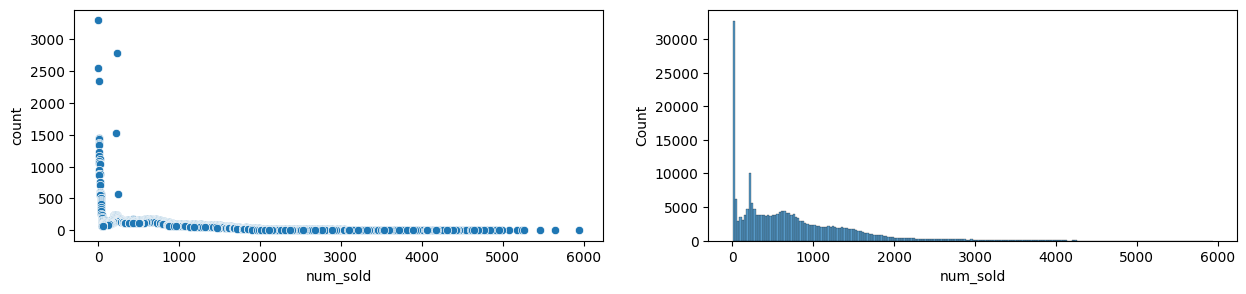

In [21]:
#Generating subplots
fig, ax = plt.subplots(1,2, figsize=(15,3))

#Generating visualizations
sns.scatterplot(df['num_sold'].value_counts(), ax=ax[0])
sns.histplot(x=df['num_sold'], ax=ax[1])
plt.show()

#Generating copy for later comparison
initial_df = df['num_sold'].copy()

In [12]:
#Dropping unnecessary columns
df.drop(columns=['date','id'], inplace=True)

#Converting catergorical values to binary values
df = pd.get_dummies(data=df, columns=['country', 'store', 'product'])
df.head(5)

,num_sold,year,quarter,month,day_of_week,is_weekend,day,week,sin_month,cos_month,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,232.0,2010,1,1,4,0,1,53,0.5,0.866025,...,False,False,True,False,False,True,False,False,False,False
1,973.0,2010,1,1,4,0,1,53,0.5,0.866025,...,False,False,True,False,False,False,True,False,False,False
2,906.0,2010,1,1,4,0,1,53,0.5,0.866025,...,False,False,True,False,False,False,False,True,False,False
3,423.0,2010,1,1,4,0,1,53,0.5,0.866025,...,False,False,True,False,False,False,False,False,True,False
4,491.0,2010,1,1,4,0,1,53,0.5,0.866025,...,False,False,True,False,False,False,False,False,False,True


In [13]:
#Defining X and y values
X= df.drop(columns=['num_sold'])
y= df['num_sold']

#Defining training and testing values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

# Displaying data split
pd.DataFrame(data={"Dimensions": [X_train.shape, y_train.size, X_test.shape, y_test.size]},
             index=["X Train", "Y Train", "X Test", "Y Test"])

,Dimensions
X Train,"(207117, 29)"
Y Train,207117
X Test,"(23013, 29)"
Y Test,23013


In [14]:
## Initializing models
dtr = DecisionTreeRegressor(random_state=42).fit(X_train,y_train)
rfr = RandomForestRegressor(random_state=42).fit(X_train,y_train)

In [15]:
#Generating empty lists to store results 
MAE = []
MSE = []
MPE = []
Model = []

In [16]:
#Generating function to store results
def results():
    results = pd.DataFrame(data={'MAE' : MAE,
                                 'MSE' : MSE,
                                 'MPE' : MPE},
                           index=Model)
    return results

In [17]:
def resultify(name:str, pred, test):
    # name = Prediction Name, pred = predicted values, test = testing values
    #Generating evaluation values
    mae_value = mean_absolute_error(pred, test)
    mse_value = mean_squared_error(pred, test)
    mpe_value = mean_absolute_percentage_error(pred, test)
    
    #Appending values to list
    Model.append(name)
    MAE.append(mae_value)
    MSE.append(mse_value)
    MPE.append(mpe_value)

In [ ]:
#Generating predictions
dpred = dtr.predict(X_test)
rpred = rfr.predict(X_test)

#Documenting results
resultify('DecisionTreeRegressor', dpred, y_test)
resultify('RandomForestRegressor', rpred, y_test)

#Displaying results
results()

,MAE,MSE,MPE
DecisionTreeRegressor,48.503802,7775.226785,0.063984
RandomForestRegressor,36.654880,4364.351916,0.048547
BaggingRegressor,36.302634,4386.803883,0.047870


In [19]:
#Importing test data and sample submission
test_df = pd.read_csv(r"C:\Users\DELL\OneDrive\Documents\Terminus\Portfolio\08. Ticket Forcasting Project\Test.csv")
forcast = pd.read_csv(r"C:\Users\DELL\OneDrive\Documents\Terminus\Portfolio\08. Ticket Forcasting Project\sample_submission.csv")

#Extract date-related features from 'date' column
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['quarter'] = pd.to_datetime(test_df['date']).dt.quarter
test_df['month'] = test_df['date'].dt.month
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['is_weekend'] = test_df['day_of_week'].isin([5, 6]).astype(int)
test_df['day'] = test_df['date'].dt.day
test_df['week'] = pd.to_datetime(test_df['date']).dt.isocalendar().week

#Add sine and cosine transformations for cyclic date features
test_df['sin_month'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['cos_month'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['sin_day'] = np.sin(2 * np.pi * test_df['day'] / 31)
test_df['cos_day'] = np.cos(2 * np.pi * test_df['day'] / 31)
test_df['sin_day_of_week'] = np.sin(2 * np.pi * test_df['day_of_week'] / 7)
test_df['cos_day_of_week'] = np.cos(2 * np.pi * test_df['day_of_week'] / 7)
test_df['sin_week'] = np.sin(2 * np.pi * test_df['week'] / 52)
test_df['cos_week'] = np.cos(2 * np.pi * test_df['week'] / 52)

#Dropping columns
test_df.drop(columns=['date','id'], inplace=True)

#Converting categorical values to binary
test_df = pd.get_dummies(data=test_df, columns=['country', 'store', 'product'])
test_df.head(4)

,year,quarter,month,day_of_week,is_weekend,day,week,sin_month,cos_month,sin_day,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,2017,1,1,6,1,1,52,0.5,0.866025,0.201299,...,False,False,True,False,False,True,False,False,False,False
1,2017,1,1,6,1,1,52,0.5,0.866025,0.201299,...,False,False,True,False,False,False,True,False,False,False
2,2017,1,1,6,1,1,52,0.5,0.866025,0.201299,...,False,False,True,False,False,False,False,True,False,False
3,2017,1,1,6,1,1,52,0.5,0.866025,0.201299,...,False,False,True,False,False,False,False,False,True,False


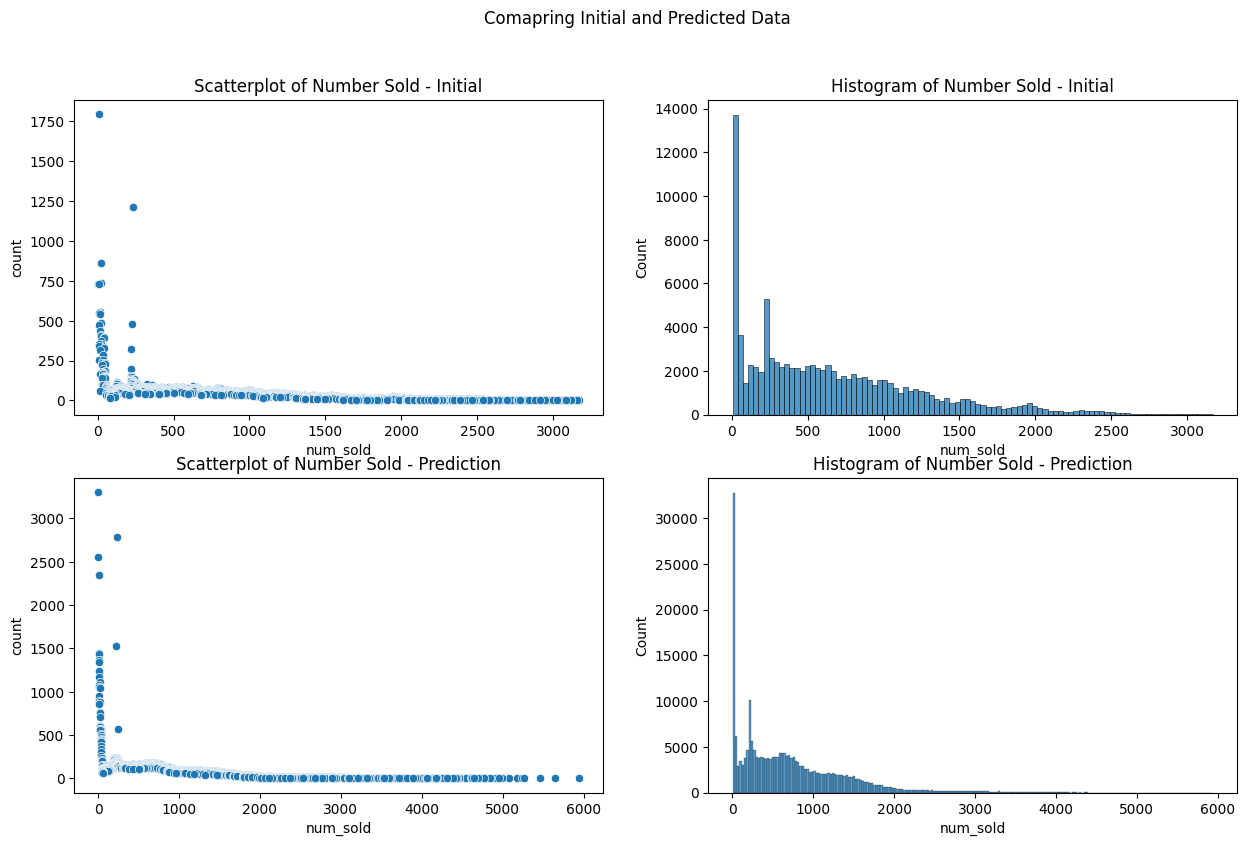

In [ ]:
#Generating predictions for rest data
pred = rfr.predict(test_df)

#Generating dataframe for predictions
submission_df = pd.DataFrame(data={"id": forcast['id'],
                           "num_sold": np.round(pred, 0)})

#Visualizing predictsions
fig, ax = plt.subplots(2,2, figsize=(15,6))
fig.suptitle('Comapring Initial and Predicted Data')

#Generating vusializations
sns.scatterplot(submission_df['num_sold'].value_counts(), ax=ax[0,0])
sns.histplot(x=submission_df['num_sold'], ax=ax[0,1])
sns.scatterplot(initial_df.value_counts(), ax=ax[1,0])
sns.histplot(x=initial_df, ax=ax[1,1])

#Labeling visualizations
ax[0,0].set_title('Scatterplot of Number Sold - Initial')
ax[0,1].set_title('Histogram of Number Sold - Initial')
ax[1,0].set_title('Scatterplot of Number Sold - Prediction')
ax[1,1].set_title('Histogram of Number Sold - Prediction')
plt.show()

In [ ]:
#submission_df.to_csv("Submission.csv", index=False)